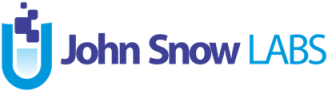

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/JohnSnowLabs/langtest/blob/main/demo/tutorials/RAG/RAG_OpenAI.ipynb)

**LangTest** is an open-source python library designed to help developers deliver safe and effective Natural Language Processing (NLP) models. Whether you are using **John Snow Labs, Hugging Face, Spacy** models or **OpenAI, Cohere, AI21, Hugging Face Inference API and Azure-OpenAI** based LLMs, it has got you covered. You can test any Named Entity Recognition (NER), Text Classification, fill-mask, Translation model using the library. We also support testing LLMS for Question-Answering, Summarization and text-generation tasks on benchmark datasets. The library supports 60+ out of the box tests. For a complete list of supported test categories, please refer to the [documentation](http://langtest.org/docs/pages/docs/test_categories).

# Evaluate RAG with LlamaIndex + Langtest


In this notebook we will look into building an RAG pipeline and evaluating it with LlamaIndex + Langtest. It has following 2 sections.


*   Building RAG with LlamaIndex.
*   Evaluating RAG with **LlamaIndex + Langtest**.




## **Build RAG system**.
Let's build a simple RAG pipeline.

In [ ]:
!pip install llama-index

In [ ]:
import nest_asyncio
nest_asyncio.apply()

from llama_index.evaluation import generate_question_context_pairs
from llama_index import VectorStoreIndex, SimpleDirectoryReader, ServiceContext
from llama_index.node_parser import SimpleNodeParser
from llama_index.evaluation import generate_question_context_pairs
from llama_index.evaluation import RetrieverEvaluator
from llama_index.llms import OpenAI

import os
import pandas as pd

In [ ]:
import os
os.environ['OPENAI_API_KEY'] = "ADD YOUR KEY"

Let's use Paul Graham Essay text for building RAG pipeline.

**Download Data**

In [ ]:
!mkdir -p 'data/paul_graham/'
!curl 'https://raw.githubusercontent.com/run-llama/llama_index/main/docs/examples/data/paul_graham/paul_graham_essay.txt' -o 'data/paul_graham/paul_graham_essay.txt'

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 75042  100 75042    0     0   633k      0 --:--:-- --:--:-- --:--:--  637k


**Load Data and Build Index.**

In [ ]:
documents = SimpleDirectoryReader("./data/paul_graham/").load_data()

# Define an LLM
llm = OpenAI(model="gpt-3.5-turbo")

# Build index with a chunk_size of 512
node_parser = SimpleNodeParser.from_defaults(chunk_size=512)
nodes = node_parser.get_nodes_from_documents(documents)
vector_index = VectorStoreIndex(nodes)

In [ ]:
query_engine = vector_index.as_query_engine()

### Evaluation
Evaluation should serve as the primary metric for assessing your RAG application. It determines whether the pipeline will produce accurate responses based on the data sources and a range of queries.


**Question-Context Pair Generation:**
For the evaluation of a RAG system, it's essential to have queries that can fetch the correct context and subsequently generate an appropriate response. `LlamaIndex` offers a generate_question_context_pairs module specifically for crafting questions and context pairs which can be used in the assessment of the RAG system of both Retrieval and Response Evaluation.

In [ ]:
qa_dataset = generate_question_context_pairs(
    nodes,
    llm=llm,
    num_questions_per_chunk=2
)

100%|██████████| 58/58 [01:37<00:00,  1.68s/it]


In [ ]:
retriever = vector_index.as_retriever(similarity_top_k=3)

Load the  **LangtestRetrieverEvaluator** from **Langtest** for evaluating the performance of a retriever model against a set of test cases and configurations.

In [ ]:
!pip install langtest
from langtest.evaluation import LangtestRetrieverEvaluator

In [ ]:
retriever_evaluator = LangtestRetrieverEvaluator.from_metric_names(
    ["mrr", "hit_rate"], retriever=retriever
)

Define retriever_evaluator. We use Hit Rate and MRR metrics to evaluate our Retriever.

**Hit Rate:**

Hit rate calculates the fraction of queries where the correct answer is found within the top-k retrieved documents. In simpler terms, it’s about how often our system gets it right within the top few guesses.

**Mean Reciprocal Rank (MRR):**

For each query, MRR evaluates the system’s accuracy by looking at the rank of the highest-placed relevant document. Specifically, it’s the average of the reciprocals of these ranks across all the queries. So, if the first relevant document is the top result, the reciprocal rank is 1; if it’s second, the reciprocal rank is 1/2, and so on.

Let's check these metrics to check the performance of out retriever.

In [ ]:
retriever_evaluator.setPerturbations("add_typo","dyslexia_word_swap", "add_ocr_typo")

**.setPerturbations()** is used to select the perturbations you want to use to generate required test cases.

In [ ]:
# Evaluate
eval_results = await retriever_evaluator.aevaluate_dataset(qa_dataset)

The retriever evaluator conducts assessments using both standard and perturbed queries created through langtest. This dual approach gauges the system's performance across normal conditions as well as its resilience and adaptability to altered or error-introduced inputs, reflecting a comprehensive understanding of the retriever's robustness and accuracy in real-world scenarios.

In [ ]:
retriever_evaluator.display_results()

,Retriever Model,Test Type,Hit Rate,MRR
0,text-embedding-ada-002,original_query,0.844828,0.686782
1,text-embedding-ada-002,add_typo,0.827586,0.682471
2,text-embedding-ada-002,dyslexia_word_swap,0.844828,0.679598
3,text-embedding-ada-002,add_ocr_typo,0.793103,0.660920


**Observation:**
In the observation of the OpenAI Embedding Retriever's performance, various test types indicate the system's robustness and accuracy under different query conditions. For the original query test, it shows a commendable hit rate of 0.844828 and an MRR of 0.686782, demonstrating solid performance under standard conditions. When introducing a typo, as seen in the "**add_typo**" test, the hit rate slightly decreases to 0.827586, and the MRR to 0.682471, indicating a small but notable impact on the retriever's effectiveness. The "**dyslexia_word_swap**" test yields a hit rate and MRR similar to the original, at 0.844828 and 0.679598 respectively, suggesting resilience to word position errors. Finally, the "**add_ocr_typo**" test shows more significant declines with a hit rate of 0.793103 and an MRR of 0.660920, underlining the challenges OCR errors pose to retrieval accuracy. These variations highlight that while the system is generally robust, its performance can be affected by perturbations in the query input, necessitating strategies for handling various types of query inaccuracies.